### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of 9 timeseries of float values, each of length 128.

The 9 timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os

### Load Data

In [1]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [3]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [4]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [6]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

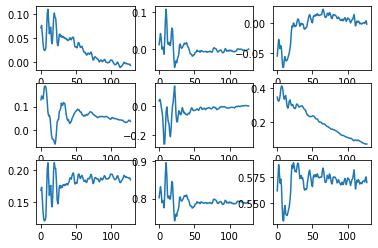

In [7]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[5], 1)

In [8]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

Can be skipped since the features are all at similar scales aready.

### Specify and Train the Model

Specify a model based on a SimpleRNN (keras.layers.SimpleRNN). 

Start with a model consisting of a single layer. Try different number of units.
Continue with adding more layers. Try to improve the test accuracy. 

In [230]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import LSTM, RNN, SimpleRNN, Dropout, GRU

from sklearn import metrics

In [214]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (max):', acc[-1])
    print('Train accuracy (end):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (end) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [217]:
import sklearn
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

### Single Layer RNN

In [208]:
# create and compile model 

n_steps    = len(X_train[0])     # 128 timesteps per series
n_input    = len(X_train[0][0])  # 9 input features per timestep
n_classes  = 6 # Total classes

### START YOUR CODE 

n_hidden   =  
batch_size = 
n_epochs   = 

...


### END YOUR CODE 

model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_32 (SimpleRNN)    (None, 32)                1312      
_________________________________________________________________
dense_28 (Dense)             (None, 6)                 198       
Total params: 1,510
Trainable params: 1,510
Non-trainable params: 0
_________________________________________________________________


In [209]:
# train the model
log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 2s 231us/sample - loss: 1.7690 - accuracy: 0.2750 - val_loss: 1.6046 - val_accuracy: 0.4313
Epoch 2/50
7352/7352 [==============================] - 1s 113us/sample - loss: 1.4768 - accuracy: 0.4450 - val_loss: 1.4097 - val_accuracy: 0.4289
Epoch 3/50
7352/7352 [==============================] - 1s 114us/sample - loss: 1.3122 - accuracy: 0.4528 - val_loss: 1.3203 - val_accuracy: 0.4805
Epoch 4/50
7352/7352 [==============================] - 1s 128us/sample - loss: 1.2010 - accuracy: 0.5264 - val_loss: 1.2202 - val_accuracy: 0.5501
Epoch 5/50
7352/7352 [==============================] - 1s 131us/sample - loss: 1.0998 - accuracy: 0.5822 - val_loss: 1.1835 - val_accuracy: 0.5436
Epoch 6/50
7352/7352 [==============================] - 1s 119us/sample - loss: 1.0259 - accuracy: 0.6106 - val_loss: 1.0769 - val_accuracy: 0.6091
Epoch 7/50
7352/7352 [==============================] - 1s 114us

Train accuracy (max): 0.73014146
Train accuracy (end): 0.73014146
Test accuracy (end) : 0.6661011
Test accuracy (end) : 0.676281


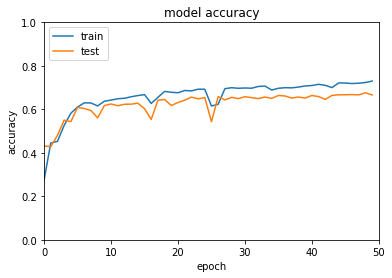

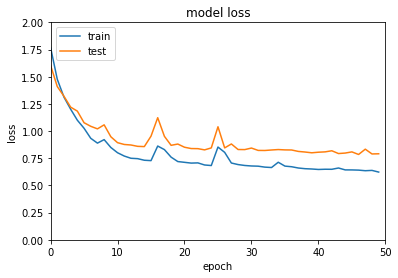

,walk,up,down,sit,stand,lay
walk,391,61,14,0,26,4
up,203,240,28,0,0,0
down,240,142,37,0,1,0
sit,1,0,0,385,104,1
stand,5,0,0,110,417,0
lay,27,0,16,0,1,493


In [219]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

## Further Model / Hyper Parameter Combinations

Examples:
* Stacked Simple RNNs
* LSTM and Stacked
* GRU and Stacked
* Conv1d + GlobalMaxPooling1D

For each combination, specify a cell with the model specification, one with the training and one with the evaluation (use for the latter the utilities provided).  


In [ ]:
...

## Report with your Findings